In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

In [2]:
# Leitura dos dados
train_df = pd.read_csv('meds_train_alunos.csv')
test_df = pd.read_csv('meds_test_alunos.csv')

In [3]:
# Seleção das colunas de sinais (RSSI) e delays conforme especificação
features = ['rssi_1_1', 'rssi_1_2', 'rssi_1_3',
            'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
            'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
            'delay_1', 'delay_2', 'delay_3']

X = train_df[features]
y = train_df[['lat', 'lon', 'indoor']]

In [4]:
# Divisão dos dados
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Função para calcular a distância entre dois pontos geográficos
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula a distância em metros entre dois pontos definidos por latitude e longitude.
    """
    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Diferenças
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Raio da Terra (m)
    r = 6371000
    return c * r

In [6]:
# Aplicação do Random Florest
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [7]:
# Definindo a função de scoring personalizada (erro médio)
def custom_scorer(estimator, X, y):
    pred = estimator.predict(X)
    errors = [haversine(y.iloc[i][0], y.iloc[i][1], pred[i][0], pred[i][1]) for i in range(len(y))]
    return np.mean(errors)

In [8]:
# Aplicando Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds

In [9]:
# Validando o modelo com Cross-Validation
cv_results = cross_val_score(rf, X, y, cv=cv, scoring=make_scorer(custom_scorer))

c:\Users\baferreira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\baferreira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\baferreira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: custom_scorer() missing 1 required positional argument: 'y'

  warnings.warn(
c:\Users\baferreira\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The sc

In [10]:
# Mostrando os resultados da validação cruzada
print("Cross-validation results:")
print(f"Mean Error: {np.mean(cv_results)} meters")
print(f"Standard Deviation of Error: {np.std(cv_results)} meters")

Cross-validation results:
Mean Error: nan meters
Standard Deviation of Error: nan meters


In [11]:
# Treinando o modelo no conjunto completo de dados
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [12]:
# Realizando as previsões no conjunto de validação
X_test = test_df[features]
pred_test = rf.predict(X_test)

In [13]:
# Predições no conjunto de treino
pred_train = rf.predict(X)

In [15]:
# Cálculo dos erros (distância em metros)
errors_rf = []
for i in range(len(y)):
    actual_lat, actual_lon = y.iloc[i][0], y.iloc[i][1]  # Coordenadas reais
    pred_lat, pred_lon = pred_train[i, 0], pred_train[i, 1]  # Coordenadas preditas (corrigido)
    error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)  # Cálculo da distância
    errors_rf.append(error)

C:\Users\baferreira\AppData\Local\Temp\ipykernel_5956\2644858523.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_lat, actual_lon = y.iloc[i][0], y.iloc[i][1]  # Coordenadas reais


In [16]:
# Métricas do Random Forest
print("Random Forest - Erro Médio:", np.mean(errors_rf))
print("Random Forest - Erro Mínimo:", np.min(errors_rf))
print("Random Forest - Erro Máximo:", np.max(errors_rf))
print("Random Forest - Desvio Padrão:", np.std(errors_rf))

Random Forest - Erro Médio: 2.236832866499916
Random Forest - Erro Mínimo: 1.0609846334830308e-09
Random Forest - Erro Máximo: 110.14796674249253
Random Forest - Desvio Padrão: 6.40117866826212


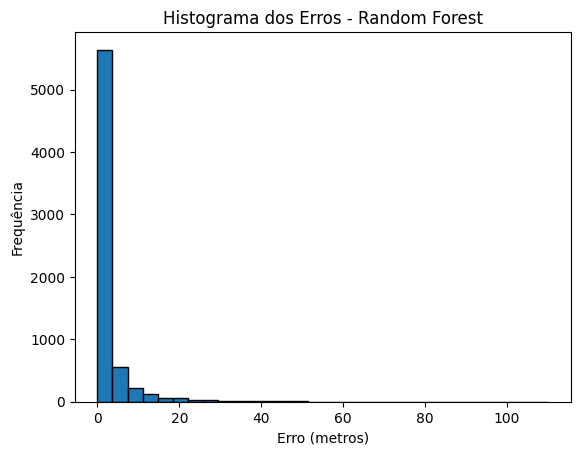

In [17]:
# Histograma dos erros
plt.figure()
plt.hist(errors_rf, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - Random Forest")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

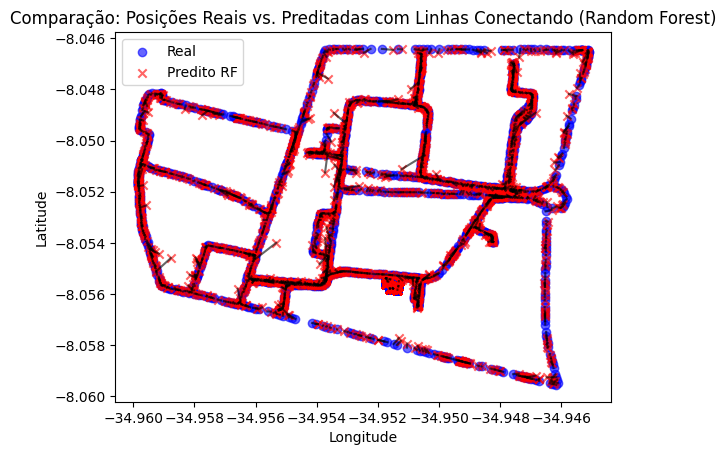

In [18]:
# Comparação: Posições Reais vs. Preditadas com Linhas Conectando
plt.figure()
plt.scatter(y['lon'], y['lat'], color='blue', label='Real', alpha=0.6)
plt.scatter(pred_train[:, 1], pred_train[:, 0], color='red', marker='x', label='Predito RF', alpha=0.6)
for i in range(len(y)):
    plt.plot([y['lon'].iloc[i], pred_train[i, 1]], [y['lat'].iloc[i], pred_train[i, 0]], color='black', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas com Linhas Conectando (Random Forest)")
plt.legend()
plt.show()

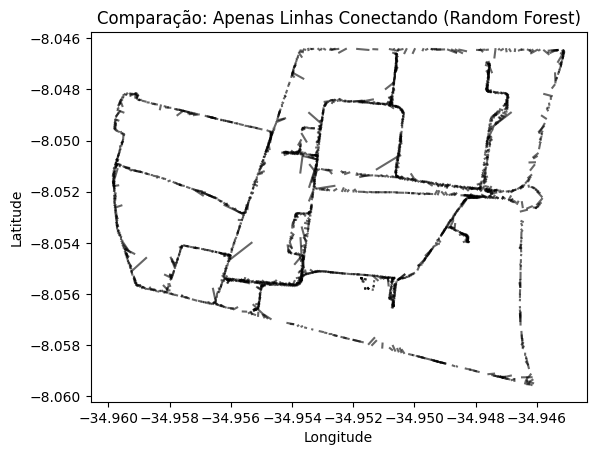

In [19]:
# Comparação: Apenas Linhas Conectando as Posições Reais e Preditadas
plt.figure()
for i in range(len(y)):
    plt.plot([y['lon'].iloc[i], pred_train[i, 1]], [y['lat'].iloc[i], pred_train[i, 0]], color='black', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Apenas Linhas Conectando (Random Forest)")
plt.show()

In [20]:
# Criação do DataFrame de submissão
submit_df = pd.DataFrame({
    'ponto_id': test_df['ponto_id'],
    'lat': pred_test[:, 0],
    'lon': pred_test[:, 1]
})

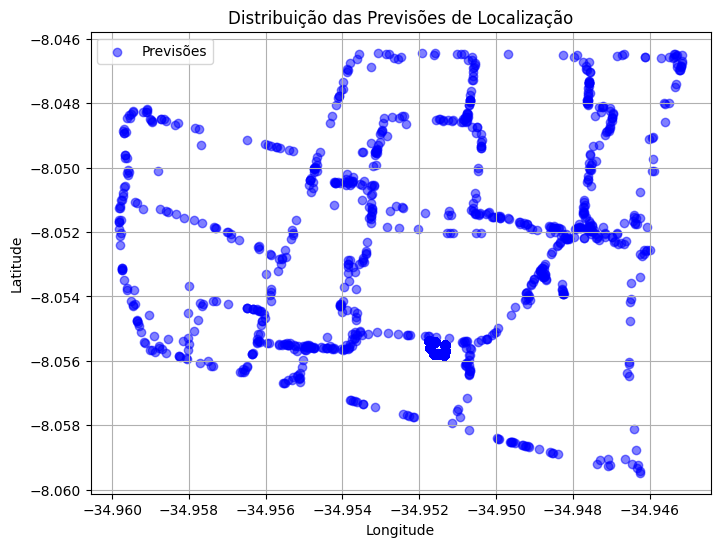

In [21]:
# Gráfico das Previsões de Localização
plt.figure(figsize=(8, 6))
plt.scatter(submit_df["lon"], submit_df["lat"], alpha=0.5, label="Previsões", color="blue")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribuição das Previsões de Localização")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Salvando o arquivo de submissão
submit_df.to_csv("Resultados_EquipeX_MetodoRF.csv", index=False)
print("Arquivo de submissão gerado: Resultados_Random_Florest_com_cross_validaton_com_indoor.csv")

Arquivo de submissão gerado: Resultados_Random_Florest_com_cross_validaton_com_indoor.csv
